# Modelisation of a radiative condenser using water as a refrigerant

In the current context, energetic economies as well as limitation over high GWP refrigerants are in the the priorities of the refrigeration sector. This project has the aim to answer two problematic: canyon urban canyon and refrigeration choice. Indeed, water as a refrigerant in terms of environmental impacts is one of the best possible. Added to that, the efficiency of a condenser is linked to the ambient temperature which is increases by those same device in urban canyon up to 2°C. This is why the main objective of the modelling is to see how can PDRC technologies (avoid heat accumulation by sending it into space) be implemented to a condenser.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy.optimize import minimize

import CoolProp.CoolProp as CP

Not understandable pics in the modelisation where seen. After investigations, it happens that the CoolProp conductivity for this range of pressure is not well set and admit a strange pic in the varation as one can see below. The corrective function will be used in the following.

The correction is made from the CoolProp density. Indeed, the conductivity and the density have the same evolution shape and with adjustment we can obtain the correct shape of the conductivity.

**Cool Prop corrections**

Superheating: x =-1.0 
SubCooling: x = -1.0


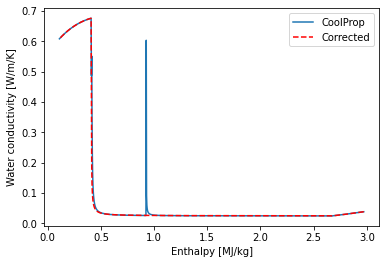

In [2]:
Ptest = 93320
Hintest,Houttest = CP.PropsSI('H','P',Ptest,'Q',1,'water'), CP.PropsSI('H','P',Ptest,'Q',0,'water')

#Change the function Lambda of CoolProp by this one approximate at the same shape as rho
def Lambda(P,H):
    if CP.PropsSI('H','P',P,'Q',0,'water')< H and H<CP.PropsSI('H','P',P,'Q',1,'water'):
        Min = (1-CP.PropsSI('D','P',P,'H',H,'water'))*CP.PropsSI('L','P',P,'Q',1,'water')
        Max = CP.PropsSI('D','P',P,'H',H,'water')*CP.PropsSI('L','P',P,'Q',0,'water')
        return ((Max+Min)/CP.PropsSI('D','P',P,'Q',0,'water'))+CP.PropsSI('L','P',P,'Q',1,'water')
    #In case of sub cooling or super heating, density does not evolve as the conductivity
    return CP.PropsSI('L','P',P,'H',H,'water')

#Plot
RHO, LAMBDA, LAMB2 = [],[],[]
HT = np.linspace(Hintest+3e5,Houttest-3e5,1000) #Plot with super heating and subcooling
RHO = [CP.PropsSI('D','P',Ptest,'H',h,'water') for h in HT]
LAMBDA, LAMB2 = [CP.PropsSI('L','P',Ptest,'H',h,'water') for h in HT],[Lambda(Ptest,h) for h in HT]

plt.plot(HT*1e-6,LAMBDA ,label = 'CoolProp')
plt.plot(HT*1e-6,LAMB2,'--',color = 'red',label = 'Corrected')
plt.xlabel('Enthalpy [MJ/kg]')
plt.ylabel('Water conductivity [W/m/K]')
plt.legend();

#Correction for the CoolProp of the title
Tintest = 70+273.15 #K
Pintest = CP.PropsSI('P','T',Tintest,'Q',1,'water')
Td = +10
Hintest = CP.PropsSI('H','P',Pintest,'T',Tintest+Td,'water') # +10 superheating: pur gas
Hintest2 = CP.PropsSI('H','P',Pintest,'T',Tintest-Td,'water') #-10 subcooling: pur liquid
print(f"""Superheating: x ={CP.PropsSI('Q','P',Pintest,'H',Hintest,'water')} 
SubCooling: x = {CP.PropsSI('Q','P',Pintest,'H',Hintest2,'water')}""") #= -1 for pur water AND pur gas: no distinction are made

def Title(P,H): #make the distinction between pur gas and pur liquid
    if H>=CP.PropsSI('H','P',P,'Q',1,'water'):
        return 1
    if H<=CP.PropsSI('H','P',P,'Q',0,'water'):
        return 0
    return CP.PropsSI('Q','H',H,'P',P,'water')

## PDRC study

**Expressions of the heat transfer done by a PDRC material**

Not yet found atmospheric data within 4-30 microns so we will stay with a PDRC in the 8-13 window for the tests
$\dot{Q}_{net}(T_w) = \pi \Bigg( \int_{8\mu m}^{13} \Big( I_{BB}(\lambda,T_w)\epsilon - I_{BB}(\lambda,T_{amb})\epsilon_{atm}(\lambda) \Big)d\lambda - \int_{0.3 \mu m}^{2.5\mu m}  \big( 1-R\big) I_{solar}(\lambda) d\lambda \Bigg) - h_{air}(T_{amb}-T_w)$

with $I_{BB} (T,\lambda)=\frac{2hc^2}{\lambda^5 (exp⁡(\frac{hc}{k_B \lambda T})-1)}$

Not yet found atmospheric data within 4-30 microns so we will stay with a PDRC in the 8-13 window for the tests

$Q_{rad} = \pi \int_{8\mu m}^{13} I_{BB}(\lambda,T_w)\epsilon d\lambda$
                                             
$Q_{atm} = \pi \int_{8\mu m}^{13} I_{BB}(\lambda,T_{amb})\epsilon_{atm}(\lambda)\epsilon d\lambda $
                    
$Q_{sun} = \pi \int_{0.3 \mu m}^{2.5\mu m}  \big( 1-R\big) I_{solar}(\lambda) d\lambda $

$ Q_{nonrad} = h_{air}(T_{amb}-T_w) $

$\dot{Q}_{net}(T_w) = Q_{rad} - Q_{atm} - Q_{sun} - Q_{nonrad} = \pi \Bigg( \int_{8\mu m}^{13} \Big( I_{BB}(\lambda,T_w)\epsilon - I_{BB}(\lambda,T_{amb})\epsilon_{atm}(\lambda) \Big)d\lambda - \int_{0.3 \mu m}^{2.5\mu m}  \big( 1-R\big) I_{solar}(\lambda) d\lambda \Bigg) - h_{air}(T_{amb}-T_w)$


with $I_{BB} (T,\lambda)=\frac{2hc^2}{\lambda^5 (exp⁡(\frac{hc}{k_B \lambda T})-1)}$

Qnonrad = -0.0 W/m2
Qrad0 = 225.0465927753187 W/m2
Qsun = 62.36529063081202 W/m2
Qatm = 26.176187662932946 W/m2
Equivalent Tciel = -125.82572408941385°C
Qnet = 145.75529154447133 W/m2 for Tc = 50°C


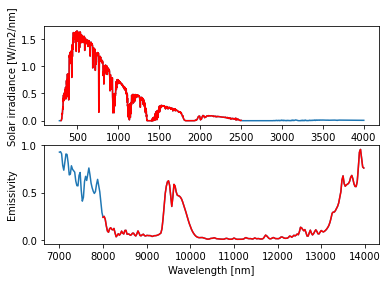

In [3]:
#Constant
hPlank = 6.62e-34 #J.s
c = 3e8 #m/s
kb = 1.38e-23 #J/K
sig = 5.67e-8 #W/m2/K4
Tamb = 30+273.15 #K
em = 0.98 #emittance
R = 0.98 #reflectance

#Importation of atmospheric data
df = pd.read_excel(r"AtmosphericData.xlsx")
df8_13 = df[df['WaveL']>=8][df[df['WaveL']>=8]['WaveL']<=14] #select the values between 8 and 13 microns
waveL = np.array([lamb*1e3 for lamb in df8_13['WaveL']]) #nm
EmAtm = np.array([em for em in df8_13['Em']])

#Importation of solar data
df2 = pd.read_excel(r'SolarData.xlsx')
df2.head()
df300_2500 = df2[df2['WaveL']>=300][df2[df2['WaveL']>=300]['WaveL']<=2500] #select the values between 0.3 and 2.5 microns
waveLsun = np.array([lamb for lamb in df300_2500['WaveL']]) #nm
Isun = np.array([I for I in df300_2500['GlobalTilt']]) #W/m2/nm

#Plot
fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(df2['WaveL'],df2['GlobalTilt'])
ax1.plot(waveLsun,Isun,'red')
ax1.set_ylabel('Solar irradiance [W/m2/nm]')

ax2.plot(df['WaveL']*1e3,df['Em'])
ax2.plot(waveL,EmAtm,'red')
ax2.set_xlabel('Wavelength [nm]')
ax2.set_ylabel('Emissivity');

#Calculation
def Ibb(T,lamb,h=hPlank,c=c,kb=kb): #W/m2/nm
    # lamb is in m
    return (2*hPlank*c**2/(lamb**5*(np.exp(hPlank*c/(kb*lamb*T))-1)))*1e-9

#Separation of the different flux of the PDRC
#Convectif
hair = 0 #W/m2/K (convective flux)
def Q_air(Tc,hair=hair,Tamb=Tamb):
    return hair*(Tamb-Tc)
Qair = Q_air(320.15);print(f'Qnonrad = {Qair} W/m2')

#Radiatif
def Q_rad(Tc):
    Rad = Ibb(Tc,waveL*1e-9)*em
    return np.pi*integrate.simpson(Rad,waveL)
#Q_rad = lambda Tc: sig*em*Tc**4
Qrad0 = Q_rad(320.15);print(f'Qrad0 = {Qrad0} W/m2')

#Solar
Sun = (1-R)*Isun
Qsun = np.pi*integrate.simpson(Sun,waveLsun);print(f'Qsun = {Qsun} W/m2')

#Atm
Atm = Ibb(Tamb,waveL*1e-9)*EmAtm*em
Qatm = np.pi*integrate.simpson(Atm,waveL); print(f'Qatm = {Qatm} W/m2')
# Tsky = -100+273.15
# Qatm = em*sig*Tsky**4; print(f'Qatm = {Qatm} W/m2')

#Equivalent Tciel
sig = 5.67e-8
Tciel = (Qatm/sig/em)**(1/4);print(f'Equivalent Tciel = {Tciel-273.15}°C')

Q_net = lambda Tc,hair=hair,Tamb=Tamb:Q_rad(Tc)-Qsun-Qatm-Q_air(Tc,hair,Tamb)

print(f'Qnet = {Q_net(323.15)} W/m2 for Tc = {50}°C')

# def Q_PDRC(Tc,hair = hair,Tamb=Tamb): #Tc in K
#     Rad = Ibb(Tc,waveL*1e-9)*em-Ibb(Tamb,waveL*1e-9)*EmAtm*em #W/m2/nm (radiation/atm spectrum within 8-13 microns)
#     Intrad = integrate.simpson(Rad,waveL)
#     Sun = (1-R)*Isun #W/m2/nm (solar spectrum within 0.3 and 2.5 microns)
#     Intsun = integrate.simpson(Sun,waveLsun)
#     Nonrad = hair*(Tamb-Tc)
#     return np.pi*(Intrad-Intsun) - Nonrad #W/m2

### Piecewise linearisation of the radiative term

In order to simplify the resolution of the system, a linearisation approach is considered for the $Q_{rad}$ component to allow different exchange surfaces.

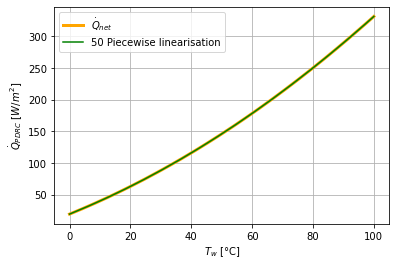

The maximum gap is 0.06864589847407387 W/m^2
The minimal R2 is 0.9996011626026271


In [4]:
#Linerarisation
N = 50
prec = 5000
def MultiLin(n=N,Tmin=0,Tmax=100,prec=prec):
    Tc = np.linspace(Tmin+273.15,Tmax+273.15,prec-N+1) # the final lenght is of size prec
    QP = [Q_rad(T) for T in Tc]
    Cut = np.arange(0,len(Tc)+1,len(Tc)//n)
    if len(Tc)%n!=0:
        Cut[-1]+= len(Tc)%n
    Coeff = [np.polyfit(Tc[Cut[0]:Cut[1]],QP[Cut[0]:Cut[1]],1)]
    ylin = [Coeff[0][0]*Tc[Cut[0]:Cut[1]]+Coeff[0][1]]
    for i in range(1,n):
        Coeff.append(np.polyfit(Tc[Cut[i]:Cut[i+1]],QP[Cut[i]:Cut[i+1]],1))
        Coeff[i][1] = ylin[i-1][-1]-Coeff[i][0]*Tc[Cut[i]-1] # continuity
        ylin.append(Coeff[i][0]*Tc[Cut[i]-1:Cut[i+1]]+Coeff[i][1]) # "Cut[i]-1" for the continuity
    return Coeff,Cut, np.concatenate(ylin)

Coeff,Cut, Y = MultiLin()

def TwcMultiLin(Q, Coeff=Coeff, QY=Y,Cut = Cut,n=N): #return Tw for a given Q
    for idx in range(n):
        y = QY[Cut[idx]:Cut[idx+1]+idx] #Cut[idx+1]+idx] for the continuity
        if Q>=np.min(y) and Q<=np.max(y):
            return (Q-Coeff[idx][1])/Coeff[idx][0]

#Plot
Tc = np.linspace(0,100,prec)
QP = np.array([Q_rad(T+273.15) for T in Tc])
plt.plot(Tc,QP-Q_air(Tc+273.15)-Qatm-Qsun,'orange',label = '$\dot{Q}_{net}$',linewidth = 3)
plt.plot(Tc,Y-Q_air(Tc+273.15)-Qatm-Qsun, 'green',label = f'{N} Piecewise linearisation')
#plt.plot(Tc,QP*2*dx*(w+et)-Qatm*w*dx-Qsun*w*dx,'orange',label = '$Q [W]$',linewidth = 3)
#plt.plot(Tc,Y*2*dx*(w+et)-Qatm*w*dx-Qsun*w*dx, 'green',label = f'{N} Piecewise linearisation')
plt.xlabel('$T_w$ [°C]')
plt.ylabel('$\dot{Q}_{PDRC} \ [W/m^2]$')
plt.legend()
plt.grid()
#plt.savefig("MultiLin.png",dpi=200)
plt.show()

#Precision
from sklearn.metrics import r2_score
print(f'The maximum gap is {np.max(abs(QP-Y))} W/m^2')
#R2 for each linearisation
R2 = []
for idx in range(N):
    R2.append(r2_score(QP[Cut[idx]:Cut[idx+1]+idx],Y[Cut[idx]:Cut[idx+1]+idx]))
print(f'The minimal R2 is {np.min(R2)}')

## Modelisation of the system

In this model, we consider the following geometry: a one channel tube discretized in mesh where the gaz goes one way and liquid can accumulate in the tube (or not if the inclinaison is enough: this will be taken into in the angle and the void rate).

Added to that fins are implented to this model. This will increases the flux for wall temperature higher than the ambient temperature, this model need to be seen with the one without fins.

**Initialisation**

In [71]:
#Fluid parameters
Ntube = 160
mwater = 3.5/Ntube;print(f'mwater = {mwater*1e3} g/s') #kg/s #Leviathan 3.5kg/s #kg/s
Tin = 65+273.15 #K
Pin = CP.PropsSI('P','T',Tin,'Q',1,'water');print(f'P_in = {Pin} Pa') #Pa
Hin= CP.PropsSI('H','P',Pin,'Q',1,'water')
Tamb = 30+273.15 #K
#Surchauffe
Tsurch = 10
Tin +=Tsurch
Hin= CP.PropsSI('H','P',Pin,'T',Tin,'water')
hair = 8 #W/m2/K #fins efficiency = 0.8
#Geometry
Lmax = 40 #m (length of the tube)
ni = int(5e3) #number of mesh
dx = Lmax/ni;print(f'dx ={dx*1e3} mm') #m (elementary length)
et = 25.4e-3 #m (tube height)
w =  190e-3 #m #tube width

e = 1.1e-3 #m (tube thickness)
theta = np.pi/3; print(f'theta ={round(theta*360/2/np.pi,0)}°') # rad (inclinaison angle)
condt = 239 #W/m/K (thermal conductivity of the material: aluminium)

G = mwater/(w*et) # kg/m2/s (water speed*density)
Dh = 4*w*et/(2*(w+et)); #m (hydraulic diameter)
K=0.4
Rein = G*Dh/CP.PropsSI('V','T',Tin,'Q',1,'water');print(f'entry Re = {Rein}') #Rel = min(Rel,Reg)
print(f'L/Dh = {Lmax/Dh}')
print(" ")

#Fins parameters ( if Tw>T)

Fp = 2.3e-3 #length between two fins #pitch 0.43 fins/mm
Ft = 0.25e-3 #thicnkess of a fin
Fs = Fp-Ft # length of air between two fins
Fl = w/3 ; print(f'Total width = {round(Ntube*(w+2*Fl),2)}m') # = w width of a fin
Fh= et # = et fin hight
Si = 4*(Fh*Fl+Fs*Fl) #unitary area of a tube ( two side + two other side)
Nfin_dx = dx/Fp #portion of fins pattern in the elementary length dx 
#Surfaces
Sair_dx = Nfin_dx*Si # area of air in dz = Srad
Ssky_dx = w*dx + 2*Nfin_dx*Fs*Fl # Ssun / Satm

mwater = 21.875 g/s
P_in = 25041.598084684127 Pa
dx =8.0 mm
theta =60.0°
entry Re = 17869.162779859318
L/Dh = 892.6647326978866
 
Total width = 50.67m


**Model**

In [72]:
#Gives the Reynold for either liquid or gas phase at saturation or Re_l in general
def Reyn(G,L,p,H=None,ph=2): 
    if ph==0: #liquid
        return G*L/CP.PropsSI('V','P',p,'Q',0,'water')
    if ph==1: #gas
        return G*L/CP.PropsSI('V','P',p,'Q',1,'water')
    return G*L/CP.PropsSI('V','P',p,'H',H,'water')

#zeta Muller
def zeta(Re): 
    if Re < 1187:
        return 64/Re
    return 0.3164/Re**(1/4)

#Void rate
def alpha(x,ro_gaz,ro_l): 
    gamm = K+(1-K)*((ro_l/ro_gaz+K*(1-x)/max(1e-7,x))/(1+K*(1-x)/max(1e-7,x)))**0.5
    return 1/(1+(1-x)/max(1e-7,x)*ro_gaz/ro_l*gamm)


#Vapor exchange coefficient
def h_vapor(P,H,x,G,Dh):
    if x>=1 or x<=1e-7:  #If monophasic
        Numono = 0.023*Reyn(G,Dh,P,H=H)**0.8*CP.PropsSI('Prandtl','P',P,'H',H,'water')**0.3
        return Lambda(P,H)/Dh*Numono
    NuL = 0.023*Reyn(G,Dh,P,ph=0)**0.8*CP.PropsSI('Prandtl','P',P,'Q',0,'water')**0.3; #Nussel liquid
    Pred = P/CP.PropsSI('Pcrit','water') #reduced pressure
    NuShah = NuL*((1-x)**0.8+3.8*x**0.76*(1-x)**0.04/Pred**0.38)
    return CP.PropsSI('L','Q',0,'P',P,'water')/Dh*NuShah

def QandTw(T,Req,Coeff=Coeff, QY=Y,Cut = Cut,n=N, hair = hair, Tamb=Tamb,
           Srad = Sair_dx,Sconv = Sair_dx,Qatm=Qatm,Qsun=Qsun,Satm=Ssky_dx,Ssun=Ssky_dx): #T en K
    #Use the multilinear approximation to resolve both equations
    for idx in range(n):
        Q = (Coeff[idx][0]*T*Srad+Coeff[idx][1]*Srad+hair*Sconv*(T-Tamb)-Qsun*Ssun-Qatm*Satm)/(1+Req*(Coeff[idx][0]*Srad+hair*Sconv))
        Tw = T-Req*Q
        y = np.array(QY[Cut[idx]:Cut[idx+1]+idx])*Srad-hair*Sconv*(Tamb-Tw)-Qatm*Satm-Qsun*Ssun
        if y[0]<=Q and y[-1]>=Q: #Check if the Q corresponds to the correct coefficient a,b
            return Q,Tw
        
#Model
def Model(mwater=mwater,Pin=Pin,Hin=Hin,Tin=Tin,theta=theta,Tamb = Tamb,hair=hair,
          Lmax=Lmax,et=et,w=w,dx=dx):
    #Init
    G ,Dh, Sair, Ssky = mwater/(w*et), 4*w*et/(2*(w+et)), Sair_dx, Ssky_dx
    hv0 = h_vapor(Pin,Hin,1,G,Dh)
    Q0,Tw0 = QandTw(Tin,e/condt/(dx*2*(w+et))+1/0.7/hv0/(dx*2*(w+et))) #adjust for Mavhi 0.7hv0
    P,H,T,TW,dPG,dPdyn,dPfr,hv,x,AL,Flux = [Pin],[Hin],[Tin],[Tw0],[0],[0],[0],[hv0],[1],[1],[Q0]
    Qair,QPDRC = [hair*Sair_dx*(Tamb-Tw0)],[Q0-hair*Sair_dx*(Tamb-Tw0)]
    for i in range(1,ni): # loop for each mesh
        #Deduce the delta enthalpy
        dH = Flux[-1]/mwater
        H.append(H[-1]-dH)
        #Deduce the vapour title
        x.append(Title(P[-1],H[-1])) # 0 for pur liquid and 1 for pur gas, other cases in [0,1]
        #Deduce Temperature
        T.append(CP.PropsSI('T','P',P[-1],'Hmass',H[-1],'water'))
        #Pressure losses du to friction
        ro_gaz = min(CP.PropsSI('D','P',P[-1],'Q',1,'water'),CP.PropsSI('D','H',H[-1],'P',P[-1],'water')) #density pur gas
        ro_liq = CP.PropsSI('D','P',P[-1],'Q',0,'water')
        A = zeta(Reyn(G,Dh,P[-1],ph=0))*G**2/2/ro_liq/Dh #64/Re #G and not mwater as in Leviathan
        B = zeta(Reyn(G,Dh,P[-1],ph=1))*G**2/2/ro_gaz/Dh #0.3164/Re**(1/4) # G and not mwater as in Leviathan
        Ge = A+2*(B-A)*x[-1]
        dP = dx*(Ge*(1-x[-1])**(1/3)+B*x[-1]**3)
        #Dynamical pressure losses
            #downstream cell
        AL.append(alpha(x[-1],ro_gaz,ro_liq))
        Pdyn1 = G**2*x[-1]**2/ro_gaz/max(1e-7,AL[-1]) + G**2*(1-x[-1])**2/ro_liq/(1-min((1-1e-7),AL[-1])) 
            #upstream cell
        indice = max(i-1,0) #at the begening P does not have 2 elements
        ro_gaz0 = min(CP.PropsSI('D','P',P[indice],'Q',1,'water'),CP.PropsSI('D','H',H[-2],'P',P[indice],'water'))
        Pdyn0 = G**2*x[-2]**2/ro_gaz0/max(1e-7,AL[-2]) + G**2*(1-x[-2])**2/ro_liq/(1-min((1-1e-7),AL[-2]))
        #Gravitational pressure losses
        dPg = dx*((1-AL[-1])*ro_liq+AL[-1]*ro_gaz)*9.81*np.sin(theta)
        dPG.append(dPG[-1]+dPg) 
        dPdyn.append(dPdyn[-1]-(Pdyn1-Pdyn0)) # the - sign corresponds to its influence on the  total pressure
        dPfr.append(dPfr[-1]-dP) # same
        P.append(P[-1]-(dP-dPg+(Pdyn1-Pdyn0)))
        Sair,Ssky = Sair+Sair_dx,Ssky+Ssky_dx
        #internal exchange coefficient calculation
        hv.append(h_vapor(P[-1],H[-1],x[-1],G,Dh))  #could depend only of P,H but x is in entry to avoid doing twice the same calculation
        #Calculation of the flux and wall temperature
        Req = e/condt/(dx*2*(w+et))+1/0.7/hv[-1]/(dx*2*(w+et-4*e))  #adjust for Mavhi 0.7hv0
        #print(T[-1],Req)
        Q,Tw = QandTw(T[-1],Req)
        Qair.append(hair*Sair_dx*(Tamb-Tw))
        QPDRC.append(Q+Qair[-1])
        Flux.append(Q)
        TW.append(Tw)
        if i%1000==0:
            print(f'{i/5000*100}%')
    return T,TW,P,x,AL,hv,dPfr,dPdyn,dPG, Flux,Qair,QPDRC,H,Sair,Ssky

In [73]:
T,Tw,P,x,AL,hv,dPfr,dPdyn,dPG, Q,Qair,QPDRC, H,Sair,Ssky = Model()

20.0%
40.0%
60.0%
80.0%


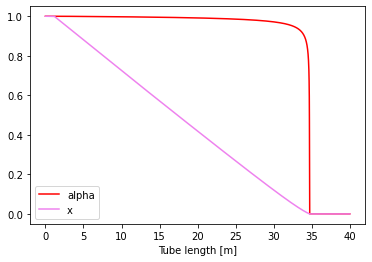

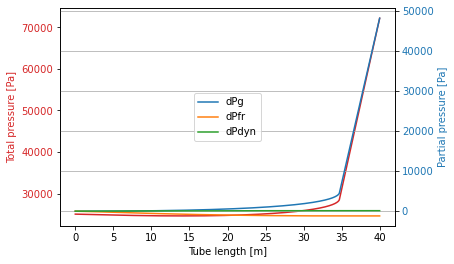

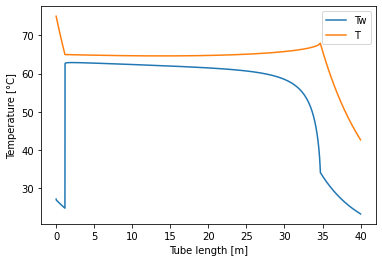

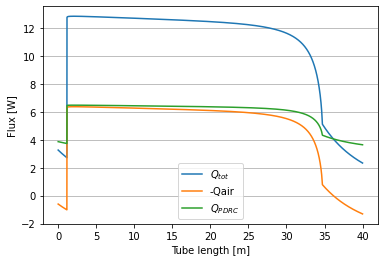

hv = [28.575020014872916,2678.074455885367] W/m2/K


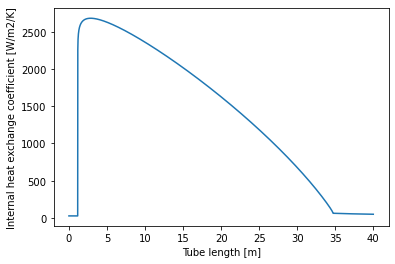

In [74]:
#Plot
Len = np.array(range(0,ni))*dx
plt.plot(Len,AL,'red',label='alpha')
plt.plot(Len,x,'violet',label='x')
plt.xlabel('Tube length [m]')
plt.legend()
#Plot the lines in and out the biphasic regim
# plt.axvline(x=Len[(np.array(T)<=Tin-Tsurch)][0],color='gray',linestyle='--') #end of the superheating
# plt.axvline(x=Len[(np.array(x)<1e-7)][0],color='gray',linestyle='--') #begening of the subcooling
#plt.savefig("title_fin.png",dpi=200)
plt.show(); #print(f'The condensation length is {round(Len[(np.array(x)<1e-7)][0],2)} m')

# Pressure
fig, ax1 = plt.subplots()
ax1.set_xlabel('Tube length [m]')
ax1.set_ylabel('Total pressure [Pa]', color='tab:red')
ax1.plot(Len, P, color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')
ax2 = ax1.twinx()
ax2.set_ylabel('Partial pressure [Pa]', color='tab:blue') 
ax2.plot(Len,dPG, label = 'dPg')
ax2.plot(Len,dPfr,label = 'dPfr')
ax2.plot(Len,dPdyn,label = 'dPdyn')
ax2.tick_params(axis='y', labelcolor='tab:blue')
# plt.axvline(x=Len[(np.array(T)<=Tin-Tsurch)][0],color='gray',linestyle='--') #end of the superheating
# plt.axvline(x=Len[(np.array(x)<1e-7)][0],color='gray',linestyle='--') #begening of the subcooling
plt.legend(loc='center')
ax2.grid()
#plt.savefig("Pressure_fin.png",dpi=200)
plt.show()

#Temperature
plt.plot(Len,(np.array(Tw)-273.15),label ='Tw')
plt.plot(Len,(np.array(T)-273.15), label = 'T')
plt.xlabel('Tube length [m]')
plt.ylabel('Temperature [°C]')
plt.legend()
# plt.axvline(x=Len[(np.array(T)<=Tin-Tsurch)][0],color='gray',linestyle='--') #end of the superheating
# plt.axvline(x=Len[(np.array(x)<1e-7)][0],color='gray',linestyle='--') #begening of the subcooling
#plt.savefig("Temperature_fin.png",dpi=200)
plt.show()

#Flux
plt.plot(Len[1:],Q[1:],label='$Q_{tot}$')
plt.plot(Len[1:],-np.array(Qair)[1:],label='-Qair')
plt.plot(Len[1:],QPDRC[1:],label='$Q_{PDRC}$')
plt.xlabel('Tube length [m]')
plt.ylabel('Flux [W]')
plt.grid(axis='y')
# plt.axvline(x=Len[(np.array(T)<=Tin-Tsurch)][0],color='gray',linestyle='--') #end of the superheating
# plt.axvline(x=Len[(np.array(x)<1e-7)][0],color='gray',linestyle='--') #begening of the subcooling
plt.legend()
#plt.savefig("Flux_fin.png",dpi=200)
plt.show()

#Internal exchange coefficient
plt.plot(Len,hv,label = 'hv');print(f'hv = [{np.min(hv)},{np.max(hv)}] W/m2/K')
plt.xlabel('Tube length [m]')
plt.ylabel('Internal heat exchange coefficient [W/m2/K]')
# plt.axvline(x=Len[(np.array(T)<=Tin-Tsurch)][0],color='gray',linestyle='--') #end of the superheating
# plt.axvline(x=Len[(np.array(x)<1e-7)][0],color='gray',linestyle='--') #begening of the subcooling
#plt.savefig("hv_fin.png",dpi=200)
plt.show();

In [ ]:
#known the final value at saturation
np.array(P)[(np.array(x)<1e-7)][0] - Pin

2020.5487420325117

## Variation analysis ( En cours)

For now, more the tube is inclined, later the condensation happen. Is it because the mass accumulation is not depedant of theta in the void rate function?

In [28]:
def Sensi(start,stop,N=100):
    PARAM = np.linspace(start,stop,100)
    T_par,Tw_par, P_par, x_par = [],[],[],[]
    for i,par in enumerate(PARAM):
        Tt,Twt,Pt,xt,_,_,_,_,_,_,_,_,_,_,_ = Model(theta = par) #CHANGE THE PARAMETER HERE
        T_par.append(Tt)
        Tw_par.append(Twt)
        P_par.append(Pt)
        x_par.append(xt)
        if i%20==0:
            print(i)
    return PARAM,T_par,Tw_par,P_par,x_par

#Theta
Theta,T_thet,Tw_thet, P_thet, x_thet = Sensi(0,np.pi/2) #Model(theta = par)

#Tin
#T_tin,Tw_tin, P_tin, x_tin = Sensi(30,70) #Model(Tin = par)

0
20
40
60
80


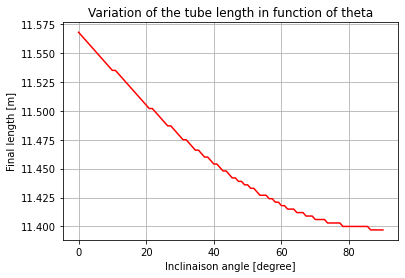

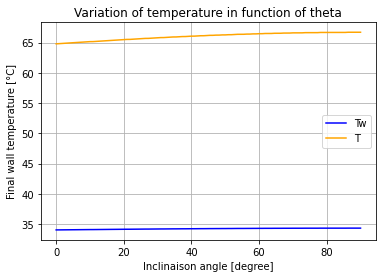

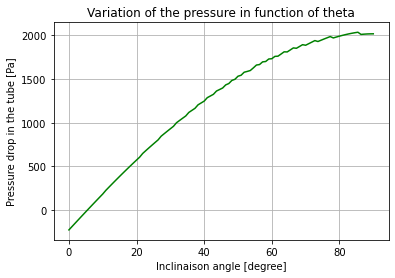

In [33]:
#Plot
def Plot(Param,Ttot,Twtot,Ptot,xtot):
    indice = []
    for i in xtot:
        if np.min(i)<1e-7: #if the length Lmax is enough to evaporate the gas
            indice.append(np.where(np.array(i)<1e-7)[0][0])
        else:
            indice.append(-1)
    Length = [Len[i] for i in indice] #Length at which there is only liquid
    T_wall = [TW[i]-273.15 for (TW,i) in zip(Twtot,indice)] #wall temperature at the end
    T_wat = [TT[i]-273.15 for (TT,i) in zip(Ttot,indice)]
    P_theta = [PF[i]-Pin for (PF,i) in zip(Ptot,indice)] #total pressure drop
    #Plot
    plt.plot(Param,Length, 'red')
    plt.ylabel('Final length [m]')
    plt.xlabel('Inclinaison angle [degree]')
    plt.title('Variation of the tube length in function of theta')
    plt.grid()
    #plt.savefig("Thet_Lenght_fins.png",dpi=200)
    plt.show();
    plt.plot(Param,T_wall,'blue',label='Tw')
    plt.plot(Param,T_wat,'orange',label='T')
    plt.ylabel('Final wall temperature [°C]')
    plt.xlabel('Inclinaison angle [degree]')
    plt.title('Variation of temperature in function of theta')
    plt.legend()
    plt.grid()
    #plt.savefig("Thet_Temp_fins.png",dpi=200)
    plt.show();
    plt.plot(Param,P_theta,'green')
    plt.ylabel('Pressure drop in the tube [Pa]')
    plt.xlabel('Inclinaison angle [degree]')
    plt.title('Variation of the pressure in function of theta');
    plt.grid()
    #plt.savefig("Thet_Pressure_fins.png",dpi=200)

#Theta
ThetaDeg = Theta*360/2/np.pi
Plot(ThetaDeg,T_thet,Tw_thet,P_thet,x_thet)

#Tin
